# Experiments on MDVR-KCL Dataset

In [9]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import auc
#from sklearn.metrics import plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import seaborn as sns
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Using Acoustic Features vs Acoustic + MFCC alone

### Read in the data that was extracted

In [4]:
# only acoustic features
df = pd.read_csv("../MDVR_acoustic_features.csv")
#df = shuffle(df)
#df.reset_index(inplace=True, drop=True)
df.drop('voiceID', inplace = True, axis = 1)
df['label'].value_counts()
df.head()

#mfcc + alc
df_all = pd.read_csv("../MDVR_all_features.csv")
#df = shuffle(df)
#df.reset_index(inplace=True, drop=True)
df_all.drop('voiceID', inplace = True, axis = 1)
df_all['label'].value_counts()
df_all.head()

,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,localShimmer,localdbShimmer,apq3Shimmer,...,mfcc_feature4,mfcc_feature5,mfcc_feature6,mfcc_feature7,mfcc_feature8,mfcc_feature9,mfcc_feature10,mfcc_feature11,mfcc_feature12,label
0,180.433976,51.653057,13.292053,0.027039,0.000151,0.012019,0.013197,0.113439,1.124025,0.046161,...,36.622796,4.381283,-51.226759,-21.675977,-7.684882,2.750536,3.849808,8.752428,0.208220,0
1,190.751972,34.887596,11.243993,0.016118,0.000085,0.006764,0.007168,0.079053,0.740666,0.029396,...,22.481075,22.888370,-16.576583,-0.005128,-22.860485,-1.250413,-8.307896,-7.638449,0.425119,0
2,124.477366,26.621493,13.423983,0.026740,0.000216,0.010862,0.011512,0.102565,0.974095,0.039042,...,31.359476,33.517867,-34.057906,-12.091941,-11.613016,-3.418581,-15.054758,1.423258,7.775569,0
3,182.557207,39.933612,12.235210,0.020701,0.000114,0.008979,0.008983,0.080388,0.811653,0.025759,...,18.603944,8.521459,-22.354081,-10.347535,-16.455566,-18.876045,10.377634,3.105279,-2.436225,0
4,195.969796,41.446983,14.669165,0.015063,0.000077,0.005371,0.006017,0.082016,0.827343,0.029087,...,26.795330,16.121763,-45.669335,-11.787999,-14.445165,0.833958,3.394994,0.135964,-6.316675,0


In [103]:
# shape
print(df_all.shape)

# descriptions
print(df_all.describe())

# class distribution
print(df_all.groupby('label').size())

(37, 25)
         meanF0Hz  stdevF0Hz        HNR  localJitter  localabsoluteJitter  \
count   37.000000  37.000000  37.000000    37.000000            37.000000   
mean   167.457574  40.580354  13.481044     0.023604             0.000151   
std     30.826544  12.639763   1.689425     0.005694             0.000062   
min     99.176942  15.856715  10.195438     0.013899             0.000077   
25%    139.689970  34.365179  12.332291     0.019678             0.000111   
50%    173.417455  39.933612  13.388906     0.022659             0.000131   
75%    190.751972  46.792915  14.583647     0.027164             0.000189   
max    214.216909  81.862069  16.854876     0.038871             0.000332   

       rapJitter  ppq5Jitter  localShimmer  localdbShimmer  apq3Shimmer  ...  \
count  37.000000   37.000000     37.000000       37.000000    37.000000  ...   
mean    0.010275    0.010958      0.096316        0.940552     0.036721  ...   
std     0.003032    0.002919      0.021066        0.17334

### EDA - CHeck outliers Visualization

<Figure size 2160x2160 with 0 Axes>

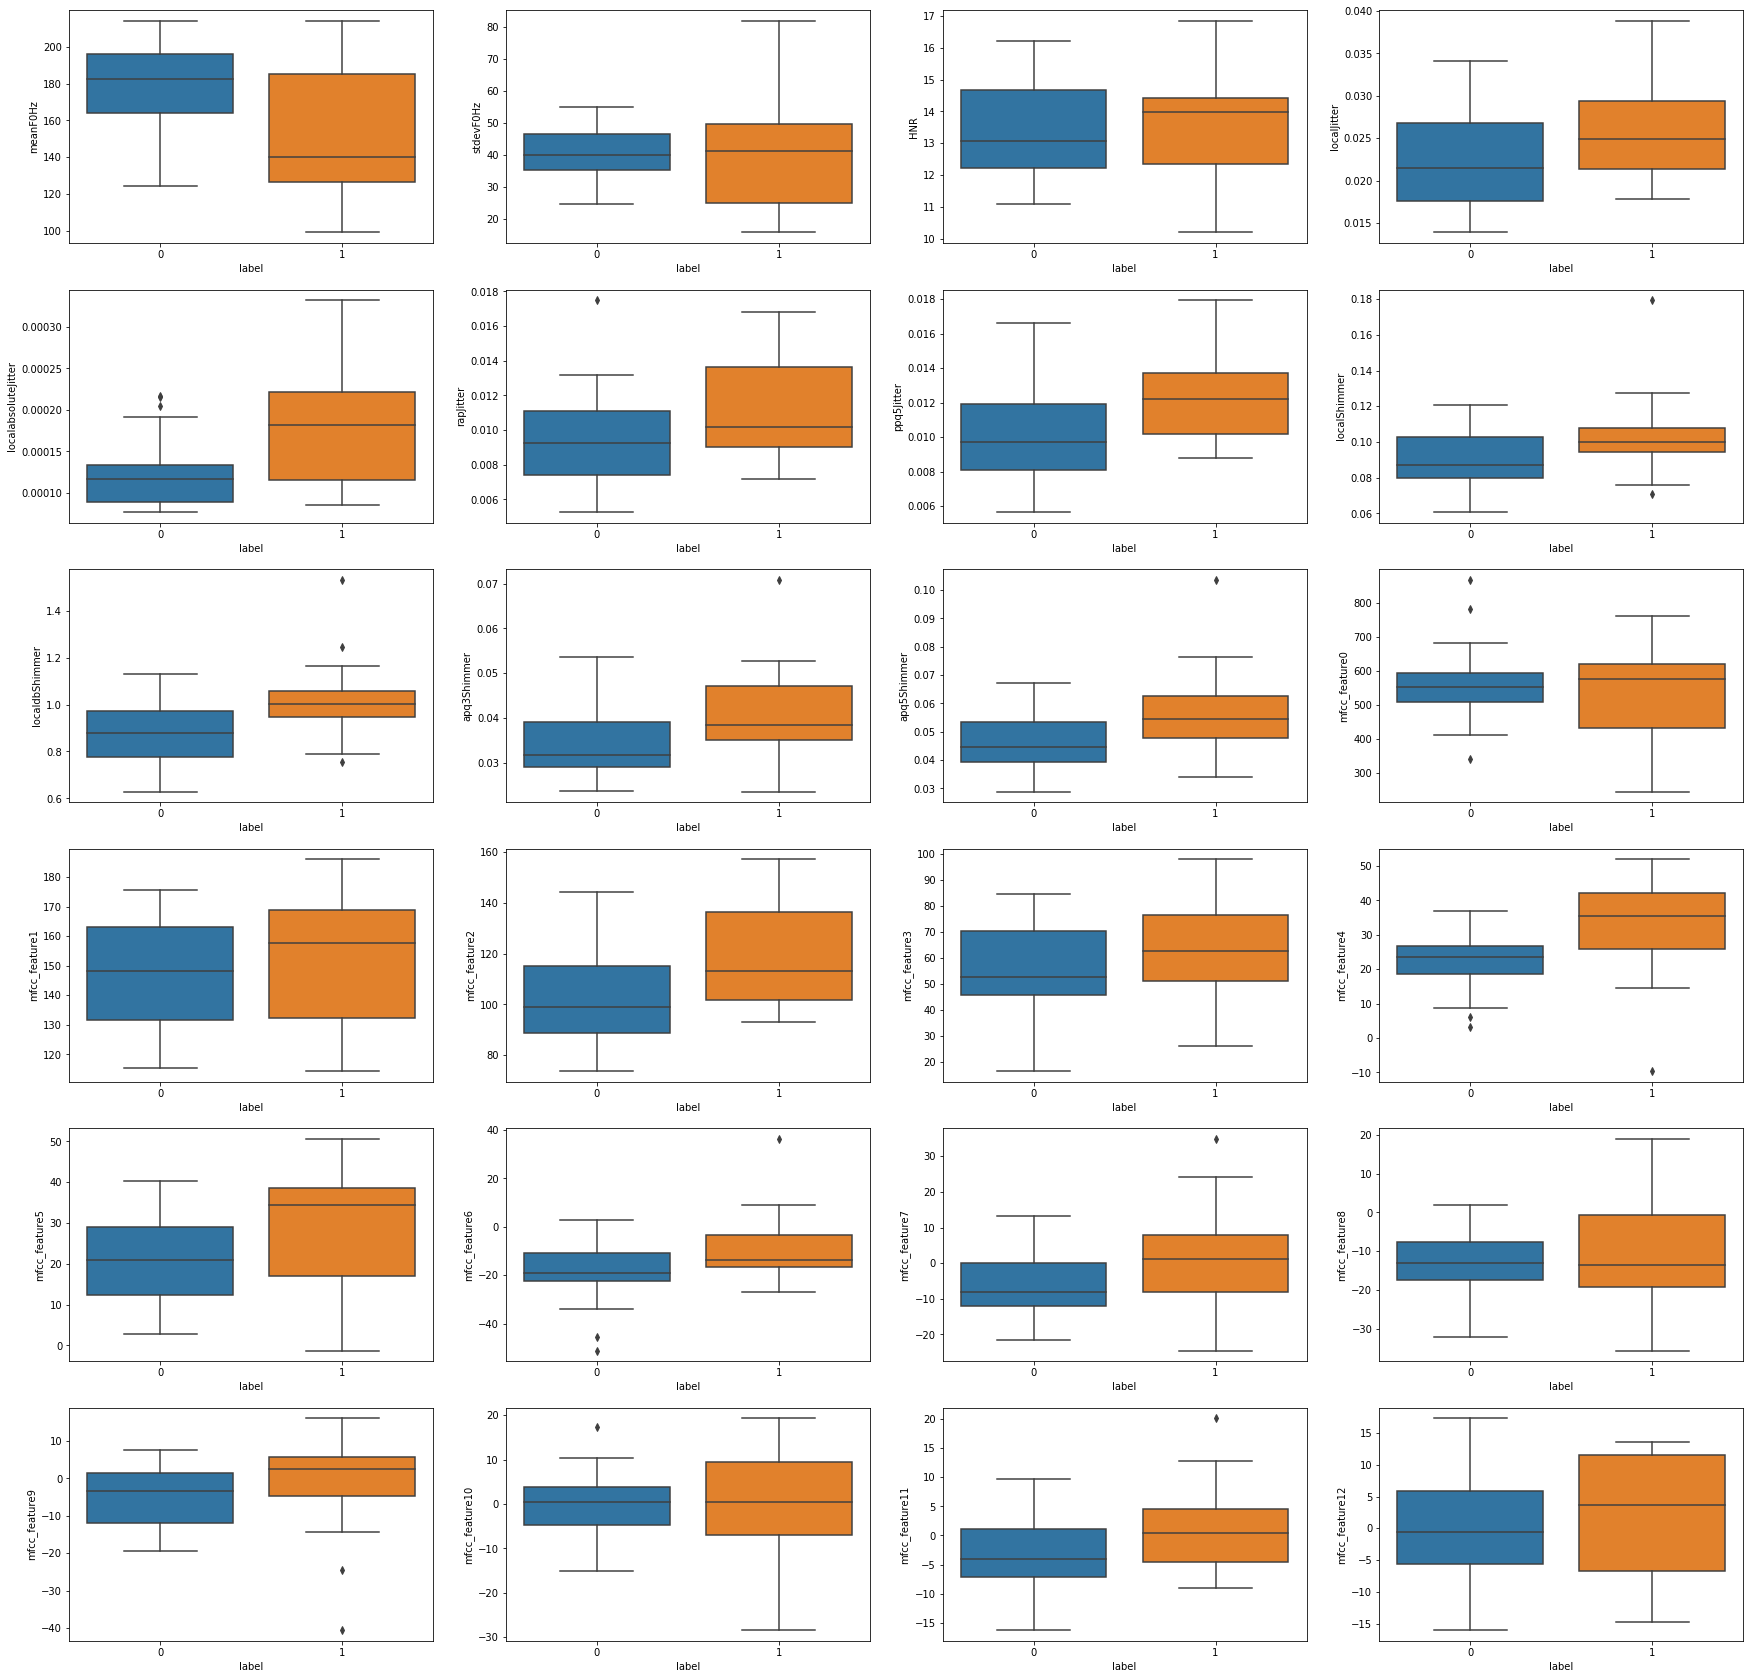

In [104]:
# histograms
plt.figure(figsize=(30,30))
#df_all.hist(figsize=(30,30))
#plt.show()

#box plot to check outliers
cols = df_all.columns.drop('label')
fig, ax = plt.subplots(6,4, figsize=(30,30))
for i,t in enumerate(cols):
    sns.boxplot(y=t, x= "label", data=df_all, ax=ax[i//4,i % 4])
plt.show()




In [101]:
df_jitter = df_all.sort_values("localabsoluteJitter")
Q1=df_jitter['localabsoluteJitter'].quantile(0.25)
Q3=df_jitter['localabsoluteJitter'].quantile(0.75)
IQR=Q3-Q1
print(Q1)
print(Q3)
print(IQR)
Lower_Whisker = Q1 - 1.5*IQR
Upper_Whisker = Q3 + 1.5*IQR

df_1 = df_jitter[df_jitter['localabsoluteJitter'] > Upper_Whisker]
df_1.append(df_jitter[df_jitter['localabsoluteJitter'] < Lower_Whisker])
df_1

0.00011058627489265645
0.00018935814179033646
7.877186689768e-05


,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,localShimmer,localdbShimmer,apq3Shimmer,...,mfcc_feature4,mfcc_feature5,mfcc_feature6,mfcc_feature7,mfcc_feature8,mfcc_feature9,mfcc_feature10,mfcc_feature11,mfcc_feature12,label
22,116.991841,58.387577,10.195438,0.038871,0.000332,0.016799,0.01793,0.127226,1.246093,0.048545,...,34.587242,35.904514,-7.150892,1.812661,-14.583591,4.764799,11.591349,-2.477217,8.576886,1


### Split dataset

In [5]:
#separate dependent and independent variable for acoustic features only
X = df.iloc[:, :-1]
df_X = df.iloc[:, :-1].values
df_Y = df.iloc[:,-1].values

# Split the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size = 0.3, random_state = 0)

#do same for all features 
df_X_all = df_all.iloc[:, :-1]
df_Y_all = df_all.iloc[:,-1]

# Split the dataset into the Training set and Test set
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(df_X_all, df_Y_all, test_size = 0.3, random_state = 0)
pd.DataFrame(X_train_all)

,meanF0Hz,stdevF0Hz,HNR,localJitter,localabsoluteJitter,rapJitter,ppq5Jitter,localShimmer,localdbShimmer,apq3Shimmer,...,mfcc_feature3,mfcc_feature4,mfcc_feature5,mfcc_feature6,mfcc_feature7,mfcc_feature8,mfcc_feature9,mfcc_feature10,mfcc_feature11,mfcc_feature12
36,185.303514,52.677109,14.082311,0.021292,0.000115,0.010419,0.009892,0.089151,0.877028,0.033184,...,29.724722,14.649535,35.371636,-13.317942,-24.561546,-35.680011,6.790475,16.044307,-0.838227,-14.727290
34,166.779713,30.941409,11.148522,0.025417,0.000153,0.013308,0.012758,0.107019,1.000508,0.049595,...,25.828700,46.257928,48.736845,-3.269747,-7.279330,-12.999099,5.743020,6.912868,4.227915,3.399261
29,131.225704,23.870219,14.041177,0.024799,0.000189,0.008344,0.010311,0.104867,1.005431,0.036322,...,30.106408,36.367023,50.162747,-3.143224,2.843856,9.975549,1.445927,-6.521557,-5.792334,11.510667
33,213.746231,45.818006,14.262968,0.020147,0.000094,0.008710,0.009108,0.071151,0.752922,0.023605,...,59.424310,-9.612589,25.461889,-17.820440,-19.583955,-14.021350,-14.216669,-15.000513,1.690258,11.802130
8,199.081279,41.081947,11.784297,0.024917,0.000125,0.011396,0.011915,0.096619,0.963974,0.033895,...,35.975529,25.900689,12.465326,-22.067320,9.601400,-17.471027,-14.222804,7.800838,-6.765283,-6.086947
13,173.417455,34.365179,14.193625,0.022659,0.000131,0.009854,0.010656,0.090751,0.878991,0.031667,...,61.964151,19.707604,25.955639,-4.058371,-2.454509,-11.914071,-11.045900,1.917227,-7.140754,-0.618947
5,168.012461,35.493510,13.020618,0.021790,0.000130,0.009273,0.009862,0.078274,0.786047,0.024992,...,46.222883,23.466147,29.100025,-10.664171,-0.847101,-23.313871,-7.849978,17.349803,-14.339421,-16.042029
17,194.704118,54.785527,13.076819,0.021499,0.000111,0.009724,0.009703,0.086963,0.876711,0.032313,...,53.358987,20.603586,38.791827,-11.357268,-11.337477,-32.091532,-19.535159,-7.135853,-1.155245,11.513905
14,179.048747,35.403221,16.224981,0.013899,0.000078,0.005279,0.005674,0.072685,0.730909,0.027094,...,64.499701,3.267962,6.959689,-22.118063,-17.566994,-10.931451,7.541269,-5.214899,-4.233492,17.294757
7,197.503773,36.631657,15.683277,0.017656,0.000090,0.007171,0.007674,0.078181,0.757354,0.029970,...,46.096491,23.799567,20.987673,-10.946063,5.476300,-4.057527,-16.016789,-4.784741,-8.588194,-2.095087


### Feature scaling

In [6]:
# Scale for acoustic features
#sc = StandardScaler()
sc = MinMaxScaler()
#sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


#do same for all features 
X_train_all = sc.fit_transform(X_train_all)
X_test_all = sc.transform(X_test_all)
pd.DataFrame(X_train_all)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.683159,0.934727,0.514127,0.365714,0.252388,0.420615,0.386582,0.466749,0.463082,0.318015,...,0.054088,0.423308,0.712416,0.788395,0.000000,0.000000,0.984414,0.971500,0.424346,0.039438
1,0.480170,0.261822,0.000000,0.569791,0.502888,0.657009,0.649233,0.761632,0.693850,0.862800,...,0.000000,0.974788,0.972276,0.997369,0.389993,0.414690,0.962670,0.772153,0.563456,0.583178
2,0.090560,0.042909,0.506918,0.539225,0.746808,0.250842,0.425005,0.726118,0.703052,0.422196,...,0.059387,0.802219,1.000000,1.000000,0.618434,0.834750,0.873468,0.478869,0.288313,0.826495
3,0.994842,0.722379,0.545786,0.309113,0.114155,0.280805,0.314770,0.169704,0.231142,0.000000,...,0.466401,0.000000,0.519740,0.694756,0.112325,0.395999,0.548330,0.293767,0.493775,0.835238
4,0.834140,0.575758,0.111415,0.545052,0.320417,0.500617,0.571964,0.589996,0.625574,0.341612,...,0.140866,0.619610,0.267048,0.606433,0.770926,0.332927,0.548203,0.791539,0.261597,0.298622
5,0.552909,0.367817,0.533634,0.433380,0.359524,0.374398,0.456565,0.493161,0.466750,0.267652,...,0.501661,0.511558,0.529340,0.980968,0.498871,0.434528,0.614152,0.663095,0.251287,0.462645
6,0.493679,0.402748,0.328072,0.390382,0.350274,0.326849,0.383806,0.287253,0.293049,0.046075,...,0.283128,0.577134,0.590477,0.843586,0.535144,0.226098,0.680495,1.000000,0.053621,0.000000
7,0.786174,1.000000,0.337921,0.375990,0.222888,0.363734,0.369304,0.430656,0.462488,0.289103,...,0.382198,0.527190,0.778915,0.829171,0.298416,0.065610,0.437924,0.465459,0.415641,0.826592
8,0.614618,0.399953,0.889615,0.000000,0.004697,0.000000,0.000000,0.195013,0.190002,0.115829,...,0.536862,0.224731,0.160002,0.605378,0.157840,0.452494,1.000000,0.507395,0.331117,1.000000
9,0.816853,0.437984,0.794685,0.185842,0.083057,0.154837,0.183334,0.285719,0.239425,0.211324,...,0.281374,0.582951,0.432748,0.837723,0.677839,0.578174,0.510962,0.516785,0.211542,0.418365


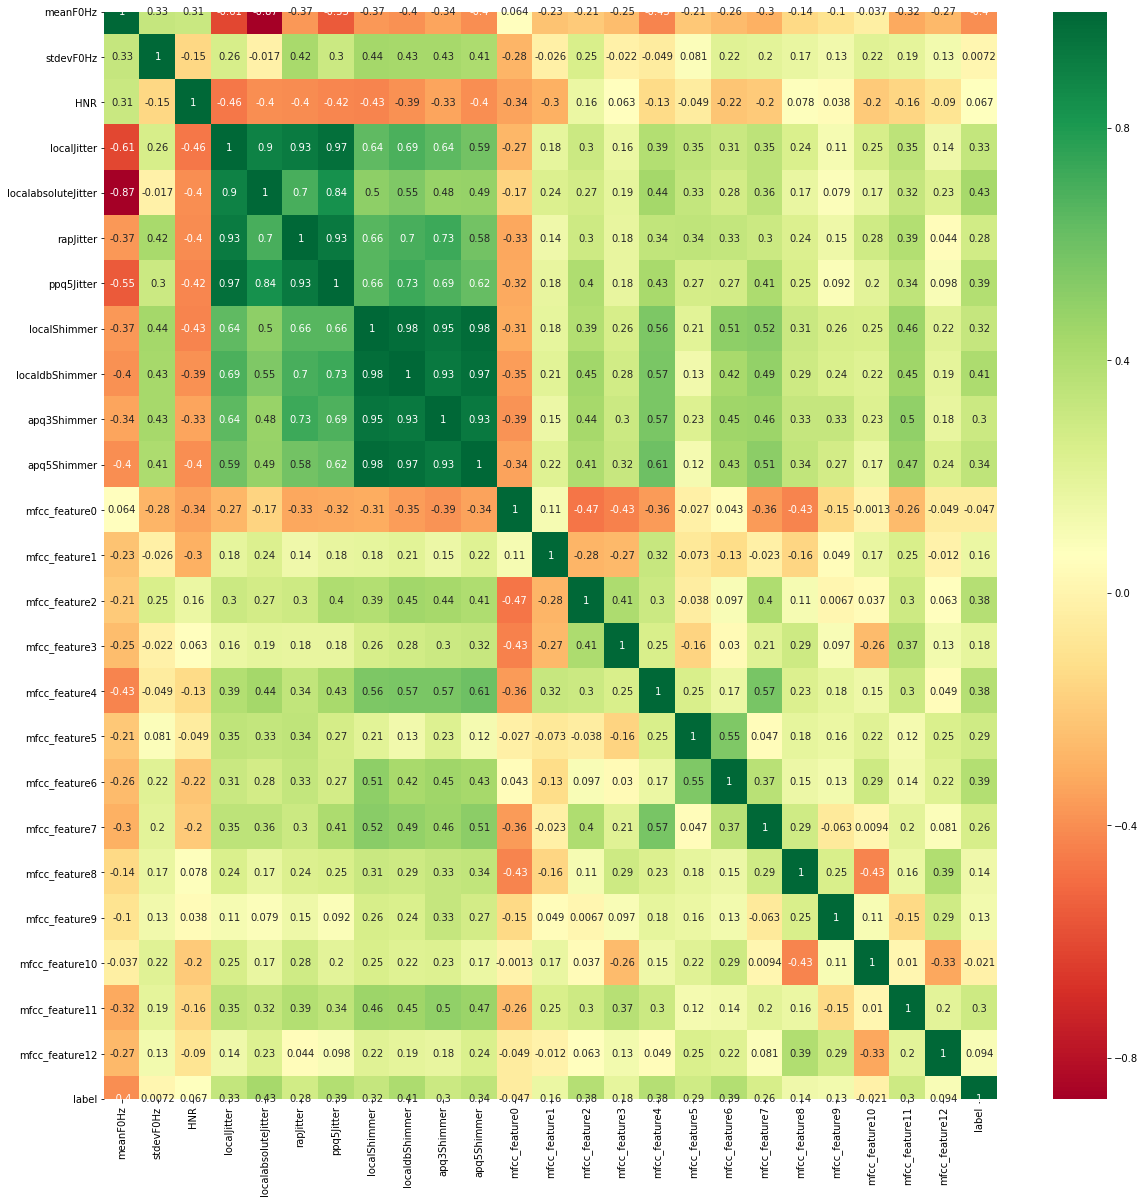

In [119]:
#data = pd.read_csv("D://Blogs//train.csv")
#X = data.iloc[:,0:20]  #independent columns
#y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = df_all.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df_all[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train_all,y_train_all)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=df_X_all.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
feat_importances.sort_values(ascending=False)

               Features     Score
8        localdbShimmer  4.461356
0              meanF0Hz  3.267059
10          apq5Shimmer  3.208661
4   localabsoluteJitter  2.837001
7          localShimmer  2.490550
17        mfcc_feature6  2.154264
22       mfcc_feature11  1.977905
21       mfcc_feature10  1.975988
13        mfcc_feature2  1.714407
1             stdevF0Hz  1.699030
15        mfcc_feature4  1.383416
11        mfcc_feature0  1.335094
9           apq3Shimmer  1.271468
6            ppq5Jitter  1.262933
3           localJitter  0.557754
12        mfcc_feature1  0.397404
16        mfcc_feature5  0.341726
19        mfcc_feature8  0.297530


Text(0, 0.5, 'f-test score')

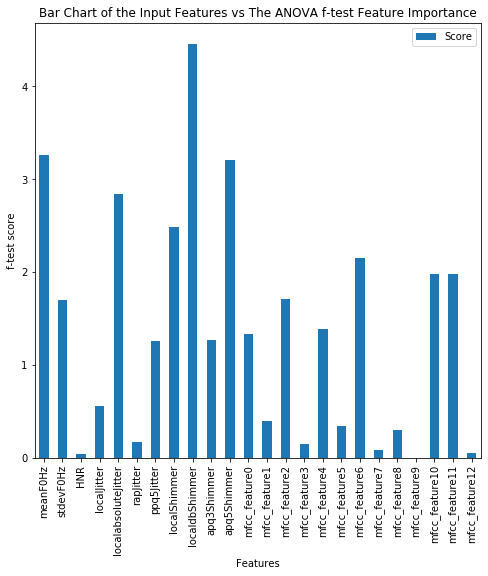

In [160]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k='all')
fit = bestfeatures.fit(X_train_all,y_train_all)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df_X_all.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
print(featureScores.nlargest(18,'Score'))  #print 10 best features
featureScores.sort_values(["Score"],ascending=False)


featureScores.plot.bar(x='Features', y='Score', figsize=(8,8))
plt.title("Bar Chart of the Input Features vs The ANOVA f-test Feature Importance")
plt.ylabel("f-test score")

# *****************KNN Experiments******************

## Build model
### without tuning the hyperparameters

In [117]:
###### KNNN ###########
# Fit classifier to the Training set
#KNN
model_knn = KNeighborsClassifier(n_neighbors = 10)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = ((conf_matrix_knn[0,0] + conf_matrix_knn[1,1])/(conf_matrix_knn[0,0] +conf_matrix_knn[0,1]+conf_matrix_knn[1,0]+conf_matrix_knn[1,1]))*100


print(accuracy_knn)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn))

print(y_pred_knn)

print(conf_matrix_knn)


###################### do same for all features (acoustic + mfcc) #####################
print("Using both acoustic and mfcc features")
model_knn_all = KNeighborsClassifier(n_neighbors = 10)
model_knn_all.fit(X_train_all, y_train_all)

y_pred_knn_all = model_knn_all.predict(X_test_all)

conf_matrix_knn_all = confusion_matrix(y_test_all, y_pred_knn_all)

accuracy_knn_all = ((conf_matrix_knn_all[0,0] + conf_matrix_knn_all[1,1])/(conf_matrix_knn_all[0,0] +conf_matrix_knn_all[0,1]+conf_matrix_knn_all[1,0]+conf_matrix_knn_all[1,1]))*100


print(accuracy_knn_all)

#Checking performance our model with classification report.
print(classification_report(y_test_all, y_pred_knn_all))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test_all, y_pred_knn_all))

print(y_pred_knn_all)

print(conf_matrix_knn_all)

66.66666666666666
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.67      0.67      0.67         6

    accuracy                           0.67        12
   macro avg       0.67      0.67      0.67        12
weighted avg       0.67      0.67      0.67        12

0.6666666666666667
[1 1 0 0 0 1 0 0 1 0 1 1]
[[4 2]
 [2 4]]
Using both acoustic and mfcc features
58.333333333333336
              precision    recall  f1-score   support

           0       0.56      0.83      0.67         6
           1       0.67      0.33      0.44         6

    accuracy                           0.58        12
   macro avg       0.61      0.58      0.56        12
weighted avg       0.61      0.58      0.56        12

0.5833333333333334
[1 1 0 0 0 1 0 0 0 0 0 0]
[[5 1]
 [4 2]]


## Hyperparameter tuning for KNN

In [8]:
########Hyperparameter tuning for KNN####################
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,20)) #neighbours must be < number of samples (22)
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

Best leaf_size: 1
Best p: 1
Best n_neighbors: 9
Best Score: 0.76
Best Hyperparameters: {'leaf_size': 1, 'n_neighbors': 9, 'p': 1}
{'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], 'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'p': [1, 2]}
83.33333333333334
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.75      1.00      0.86         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12

0.8333333333333334
[1 1 0 0 1 1 0 0 1 1 1 1]
[1 0 0 0 1 1 0 0 0 1 1 1]
[[4 2]
 [0 6]]


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model
### using the optimal parameters gotten above

In [111]:
model_knn = KNeighborsClassifier(n_neighbors = 9, p = 1, leaf_size = 1)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = ((conf_matrix_knn[0,0] + conf_matrix_knn[1,1])/(conf_matrix_knn[0,0] +conf_matrix_knn[0,1]+conf_matrix_knn[1,0]+conf_matrix_knn[1,1]))*100


print(accuracy_knn)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn))

print(y_pred_knn)
print(y_test)
print(conf_matrix_knn)

####################using the acoustic + MFCC


83.33333333333334
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.75      1.00      0.86         6

    accuracy                           0.83        12
   macro avg       0.88      0.83      0.83        12
weighted avg       0.88      0.83      0.83        12

0.8333333333333334
[1 1 0 0 1 1 0 0 1 1 1 1]
[1 0 0 0 1 1 0 0 0 1 1 1]
[[4 2]
 [0 6]]
Using both acoustic and mfcc features
66.66666666666666
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.67      0.67      0.67         6

    accuracy                           0.67        12
   macro avg       0.67      0.67      0.67        12
weighted avg       0.67      0.67      0.67        12

0.6666666666666667
[1 1 0 0 0 1 0 0 1 1 1 0]
[1 0 0 0 1 1 0 0 0 1 1 1]
[[4 2]
 [2 4]]


## Evaluation 


### Evaluation with Leave one out method -IGNORE

In [112]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
model_knn_kfold = KNeighborsClassifier(n_neighbors = 9, p =1, leaf_size = 1)
y_pred_kfold_knn = cross_val_predict(model_knn_kfold, df_X, df_Y, cv=k_fold)

scores = cross_val_score(model_knn_kfold, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_knn)
conf_matrix_knn_kfold = confusion_matrix(df_Y, y_pred_kfold_knn)
print("Confusion Matrix for KNN using k-fold (leave one out)")
print(conf_matrix_knn_kfold)


accuracy_knn_2 = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/(conf_matrix_knn_kfold[0,0] +conf_matrix_knn_kfold[0,1]+conf_matrix_knn_kfold[1,0]+conf_matrix_knn_kfold[1,1]))*100


print(accuracy_knn_2)

Accuracy: 0.649 (0.477)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0]
Confusion Matrix for KNN using k-fold (leave one out)
[[18  3]
 [10  6]]
64.86486486486487


### K Fold Evaluation using optimal paramaters. (k =3)


In [10]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_list = []

k_specificity = []
k_sensitivity = []
k_precision = []
k_f1 = []
for i in range (1,12):
    row = []
    row_specificity = []
    row_sensitivity = []
    row_precision = []
    row_f1 = []
    row.append(i)
    row_specificity.append(i)
    row_sensitivity.append(i)
    row_precision.append(i)
    row_f1.append(i)
    total = 0
    total_specificity = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    #print("Loop", i)
   #for j, (train, test) in kfold.split(X_kfold,y_kfold):
    for j, (train, test) in enumerate(kfold.split(X_kfold, y_kfold)):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)
        #print(Ytrain_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        model_knn_new = KNeighborsClassifier(n_neighbors = 9, p =1, leaf_size = 1)
        model_knn_new.fit(Xtrain_kfold, Ytrain_kfold)
        y_pred_knn_new = model_knn_new.predict(Xtest_kfold)

        conf_matrix_knn_kfold = confusion_matrix(Ytest_kfold, y_pred_knn_new)
        TN = conf_matrix_knn_kfold[0][0]
        FP = conf_matrix_knn_kfold[0][1]
        FN = conf_matrix_knn_kfold[1][0]
        TP = conf_matrix_knn_kfold[1][1]
        
        
        #total = (conf_matrix_knn_kfold[0,0] +conf_matrix_knn_kfold[0,1]+conf_matrix_knn_kfold[1,0]+conf_matrix_knn_kfold[1,1])

        #accuracy_knn_kfold = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/total)*100
        accuracy_knn_kfold = ((TP + TN) / (TP + TN + FP + FN)) * 100
        sensitivity_knn_kfold = (TP/(TP+FN)) * 100 #recall
        specificity_knn_kfold = (TN/(TN + FP)) * 100
        precision_knn_kfold = (TP/(TP+FP))
        f1_knn_kfold = 2 *((sensitivity_knn_kfold * precision_knn_kfold)/(sensitivity_knn_kfold + precision_knn_kfold))
        #sensitivity_knn_kfold = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/total)*100

        #print("Confusion Matrix:\n ", conf_matrix_knn_kfold)
        #print("Accuracy ", accuracy_knn_kfold)

        row.append(accuracy_knn_kfold)
        row_specificity.append(sensitivity_knn_kfold)
        row_sensitivity.append(specificity_knn_kfold)
        row_precision.append(precision_knn_kfold)
        row_f1.append(f1_knn_kfold)
        
        total += accuracy_knn_kfold
        total_specificity = specificity_knn_kfold
        total_sensitivity = sensitivity_knn_kfold
        total_precision = precision_knn_kfold
        total_f1 = f1_knn_kfold
        
        #plot roc only for the first iteration
        if i == 1:
            metrics.plot_roc_curve(model_knn_new, Xtest_kfold, Ytest_kfold,name='ROC fold {}'.format(j),
                         alpha=0.3, lw=1, ax=ax)
        
        
    average = row.append(total/parts)
    
    row_specificity.append(total_specificity/parts)
    row_sensitivity.append(total_sensitivity/parts)
    row_precision.append(total_precision/parts)
    row_f1.append(total_f1/parts)
        
    #print(row)
    k_list.append(row)
    k_specificity.append(row_specificity)
    k_sensitivity.append(row_sensitivity)
    k_precision.append(row_precision)
    k_f1.append(row_f1)
    
      
k_list = pd.DataFrame(k_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Classification Accuracy")
print(k_list)
    

k_specificity = pd.DataFrame(k_specificity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean specificity'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Specificity")
print(k_specificity)

k_sensitivity = pd.DataFrame(k_sensitivity, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean sensitivity/recall'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Sensitivity/Recall")
print(k_sensitivity)

k_precision = pd.DataFrame(k_precision, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean precision'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - Precision")
print(k_precision)

k_f1 = pd.DataFrame(k_f1, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean f1 score'])
print("KNN Kfold Evaluation for MDVR-KCL Dataset - F1 score")
print(k_f1)
    
    
    
#print(df.sample(n=7))
#print(df)

#x = df.take(np.random.permutation(len(df))[:4])
#x= df.sample(n=7)
#print(x)
#print(df.drop(x))

#drop_indices = np.random.choice(df.index, 4, replace=False)
#df_subset = df.drop(drop_indices)
#print(drop_indices)
#print(df_subset)

    
    


Divided into 4 parts.


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


AttributeError: module 'sklearn.metrics' has no attribute 'plot_roc_curve'

### Other Evaluation metrics

In [172]:
pip install -U sklearn

  Using cached https://files.pythonhosted.org/packages/1e/7a/dbb3be0ce9bd5c8b7e3d87328e79063f8b263b2b1bfa4774cb1147bfcd3f/sklearn-0.0.tar.gz
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=5ed33ccd4c11c93de8ea56542b7bed1d484b876ebc3c2c5ba06d9d986432bb34
  Stored in directory: C:\Users\Aeesha\AppData\Local\pip\Cache\wheels\76\03\bb\589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [8]:
!python -m pip install -U sklearn

  Using cached sklearn-0.0.tar.gz (1.1 kB)
Using legacy 'setup.py install' for sklearn, since package 'wheel' is not installed.
    Running setup.py install for sklearn: started
    Running setup.py install for sklearn: finished with status 'done'



# *****************Decision Tree Experiments***************

## Build model
### without tuning the hyperparameters

75.0
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.67      1.00      0.80         6

    accuracy                           0.75        12
   macro avg       0.83      0.75      0.73        12
weighted avg       0.83      0.75      0.73        12

0.75
[1 1 0 0 1 1 0 1 1 1 1 1]
[[3 3]
 [0 6]]


[Text(334.8, 684.9359999999999, 'X[0] <= 0.279\ngini = 0.48\nsamples = 25\nvalue = [15, 10]'),
 Text(167.4, 532.728, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(502.20000000000005, 532.728, 'X[6] <= 0.254\ngini = 0.408\nsamples = 21\nvalue = [15, 6]'),
 Text(334.8, 380.52, 'gini = 0.0\nsamples = 6\nvalue = [6, 0]'),
 Text(669.6, 380.52, 'X[3] <= 0.376\ngini = 0.48\nsamples = 15\nvalue = [9, 6]'),
 Text(334.8, 228.312, 'X[0] <= 0.668\ngini = 0.408\nsamples = 7\nvalue = [2, 5]'),
 Text(167.4, 76.10399999999993, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(502.20000000000005, 76.10399999999993, 'gini = 0.0\nsamples = 5\nvalue = [0, 5]'),
 Text(1004.4000000000001, 228.312, 'X[2] <= 0.056\ngini = 0.219\nsamples = 8\nvalue = [7, 1]'),
 Text(837.0, 76.10399999999993, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(1171.8, 76.10399999999993, 'gini = 0.0\nsamples = 7\nvalue = [7, 0]')]

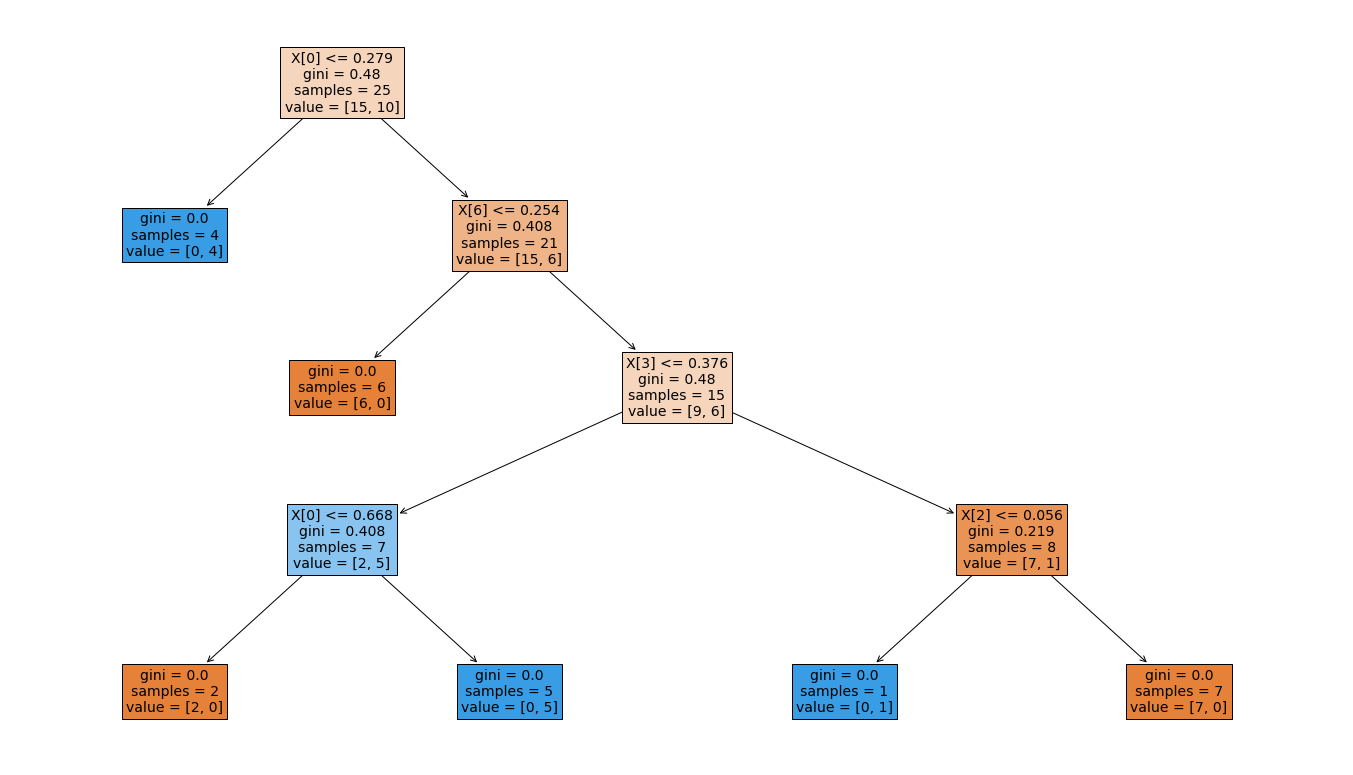

In [14]:
###### KNNN ###########
# Fit classifier to the Training set
#Decision Tree
import matplotlib.pyplot as plt
model_dt = tree.DecisionTreeClassifier()
model_dt = model_dt.fit(X_train, y_train)

y_pred_knn = model_dt.predict(X_test)

conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

accuracy_knn = ((conf_matrix_knn[0,0] + conf_matrix_knn[1,1])/(conf_matrix_knn[0,0] +conf_matrix_knn[0,1]+conf_matrix_knn[1,0]+conf_matrix_knn[1,1]))*100


print(accuracy_knn)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn))

print(y_pred_knn)

print(conf_matrix_knn)

plt.figure(figsize=(24,14))
tree.plot_tree(model_dt, filled=True, fontsize=14)

## Hyperparameter tuning for Decision Trees

In [17]:
########Hyperparameter tuning for KNN####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
max_depth = list(range(1,10))
min_samples_split = list(range(2,10)) #neighbours must be < number of samples (22)
min_samples_leaf = list(range(1,5))
criterion=['gini','entropy']
#Convert to dictionary
hyperparameters = dict(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, criterion = criterion)
#Create new KNN object
dt_2 = tree.DecisionTreeClassifier()

cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(dt_2, hyperparameters, refit=True)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best Score: 0.6
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9], 'min_samples_leaf': [1, 2, 3, 4], 'criterion': ['gini', 'entropy']}
75.0
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

0.7500000000000002
[1 1 0 0 1 1 0 0 1 0 1 1]
[1 0 0 0 1 1 0 0 0 1 1 1]
[[4 2]
 [1 5]]


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model (Decision Tree)
### using the optimal parameters gotten above

In [18]:
#model_dt = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_dt = tree.DecisionTreeClassifier(max_depth = 1, criterion='gini',min_samples_leaf=1, min_samples_split=2 )
model_dt = model_dt.fit(X_train, y_train)

y_pred_dt_2 = best_model.predict(X_test)

conf_matrix_dt_2 = confusion_matrix(y_test, y_pred_dt_2)

accuracy_dt_2 = ((conf_matrix_dt_2[0,0] + conf_matrix_dt_2[1,1])/(conf_matrix_dt_2[0,0] +conf_matrix_dt_2[0,1]+conf_matrix_dt_2[1,0]+conf_matrix_dt_2[1,1]))*100

print(conf_matrix_dt_2)
print(accuracy_dt_2)

[[4 2]
 [1 5]]
75.0


## Evaluation 


### Evaluation with Leave one out method

In [21]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
#model_knn_kfold = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_dt = tree.DecisionTreeClassifier(max_depth = 1, criterion='gini',min_samples_leaf=1, min_samples_split=2 )
y_pred_kfold_knn = cross_val_predict(model_dt, df_X, df_Y, cv=k_fold)
scores = cross_val_score(model_dt, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_knn)
conf_matrix_knn_kfold = confusion_matrix(df_Y, y_pred_kfold_knn)
print("Confusion Matrix for Dt using k-fold (leave one out)")
print(conf_matrix_knn_kfold)


accuracy_knn_2 = ((conf_matrix_knn_kfold[0,0] + conf_matrix_knn_kfold[1,1])/(conf_matrix_knn_kfold[0,0] +conf_matrix_knn_kfold[0,1]+conf_matrix_knn_kfold[1,0]+conf_matrix_knn_kfold[1,1]))*100


print(accuracy_knn_2)

Accuracy: 0.568 (0.495)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0]
Confusion Matrix for Dt using k-fold (leave one out)
[[17  4]
 [11  5]]
59.45945945945946


### K Fold Evaluation using optimal paramaters. (k =4)


In [25]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_list = []

for i in range (1,12):
    row = []
    row.append(i)
    total = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        #model_knn_new = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
        model_dt_new = tree.DecisionTreeClassifier(max_depth = 1, criterion='gini',min_samples_leaf=1, min_samples_split=2 )
        model_dt_new.fit(Xtrain_kfold, Ytrain_kfold)
        y_pred_dt_new = model_dt_new.predict(Xtest_kfold)

        conf_matrix_dt_kfold = confusion_matrix(Ytest_kfold, y_pred_dt_new)

        accuracy_dt_kfold = ((conf_matrix_dt_kfold[0,0] + conf_matrix_dt_kfold[1,1])/(conf_matrix_dt_kfold[0,0] +conf_matrix_dt_kfold[0,1]+conf_matrix_dt_kfold[1,0]+conf_matrix_dt_kfold[1,1]))*100

        #print("Confusion Matrix:\n ", conf_matrix_knn_kfold)
        #print("Accuracy ", accuracy_knn_kfold)

        row.append(accuracy_dt_kfold)
        total += accuracy_dt_kfold
    average = row.append(total/parts)
        
    #print(row)
    k_list.append(row)
    
k_list = pd.DataFrame(k_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Decsion Tree Kfold Evaluation for MDVR-KCL Dataset")
k_list
    

    
    
    
#print(df.sample(n=7))
#print(df)

#x = df.take(np.random.permutation(len(df))[:4])
#x= df.sample(n=7)
#print(x)
#print(df.drop(x))

#drop_indices = np.random.choice(df.index, 4, replace=False)
#df_subset = df.drop(drop_indices)
#print(drop_indices)
#print(df_subset)

    
    


Divided into 4 parts.
Decsion Tree Kfold Evaluation for MDVR-KCL Dataset


,Loops,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,60.0,66.666667,55.555556,77.777778,65.000000
1,2,40.0,44.444444,66.666667,55.555556,51.666667
2,3,60.0,55.555556,44.444444,55.555556,53.888889
3,4,60.0,55.555556,66.666667,66.666667,62.222222
4,5,80.0,55.555556,33.333333,66.666667,58.888889
5,6,70.0,66.666667,44.444444,66.666667,61.944444
6,7,50.0,55.555556,66.666667,55.555556,56.944444
7,8,70.0,55.555556,55.555556,77.777778,64.722222
8,9,60.0,55.555556,66.666667,44.444444,56.666667
9,10,70.0,22.222222,33.333333,55.555556,45.277778



# *****************SVM Experiments***************

## Build model
### without tuning the hyperparameters

In [26]:
###### KNNN ###########
# Fit classifier to the Training set
#Decision Tree
import matplotlib.pyplot as plt
model_svm = svm.SVC()
model_svm = model_dt.fit(X_train, y_train)

y_pred_svm = model_dt.predict(X_test)

conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

accuracy_svm = ((conf_matrix_svm[0,0] + conf_matrix_svm[1,1])/(conf_matrix_svm[0,0] +conf_matrix_svm[0,1]+conf_matrix_svm[1,0]+conf_matrix_svm[1,1]))*100


print(accuracy_svm)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_svm))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_svm))

print(y_pred_svm)

print(conf_matrix_svm)


50.0
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.50      0.33      0.40         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.49        12
weighted avg       0.50      0.50      0.49        12

0.5
[0 1 0 0 1 0 0 0 1 0 1 0]
[[4 2]
 [4 2]]


## Hyperparameter tuning for SVM

In [27]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
C = [0.1, 1, 10, 100, 1000]
gamma = [1, 0.1, 0.01, 0.001, 0.0001]
kernel = ['rbf']

#Convert to dictionary
hyperparameters = dict(C=C, gamma=gamma, kernel=kernel)
#Create new KNN object
svm2 = svm.SVC()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(svm2, hyperparameters, refit=True)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

Best Score: 0.68
Best Hyperparameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
{'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
66.66666666666666
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.67      0.67      0.67         6

    accuracy                           0.67        12
   macro avg       0.67      0.67      0.67        12
weighted avg       0.67      0.67      0.67        12

0.6666666666666667
[1 1 0 0 1 1 0 0 1 0 1 0]
[1 0 0 0 1 1 0 0 0 1 1 1]
[[4 2]
 [2 4]]


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model (SVM)
### using the optimal parameters gotten above

In [28]:
model_svm = svm.SVC(C = 10, gamma=0.1,kernel='rbf')
model_svm = model_svm.fit(X_train, y_train)

y_pred_svm_2 = best_model.predict(X_test)

conf_matrix_svm_2 = confusion_matrix(y_test, y_pred_svm_2)

accuracy_svm_2 = ((conf_matrix_svm_2[0,0] + conf_matrix_svm_2[1,1])/(conf_matrix_svm_2[0,0] +conf_matrix_svm_2[0,1]+conf_matrix_svm_2[1,0]+conf_matrix_svm_2[1,1]))*100

print(conf_matrix_svm_2)
print(accuracy_svm_2)

[[4 2]
 [2 4]]
66.66666666666666


## Evaluation (SVM) 


### Evaluation with Leave one out method

In [29]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
#model_knn_kfold = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_svm = svm.SVC(C = 10, gamma=0.1,kernel='rbf')
y_pred_kfold_svm = cross_val_predict(model_svm, df_X, df_Y, cv=k_fold)
scores = cross_val_score(model_svm, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_knn)
conf_matrix_svm_kfold = confusion_matrix(df_Y, y_pred_kfold_svm)
print("Confusion Matrix for Dt using k-fold (leave one out)")
print(conf_matrix_svm_kfold)


accuracy_svm_2 = ((conf_matrix_svm_kfold[0,0] + conf_matrix_svm_kfold[1,1])/(conf_matrix_svm_kfold[0,0] +conf_matrix_svm_kfold[0,1]+conf_matrix_svm_kfold[1,0]+conf_matrix_svm_kfold[1,1]))*100


print(accuracy_svm_2)

Accuracy: 0.757 (0.429)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0]
Confusion Matrix for Dt using k-fold (leave one out)
[[17  4]
 [ 5 11]]
75.67567567567568


### K Fold Evaluation using optimal paramaters. (k =4)


In [32]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_list = []

for i in range (1,12):
    row = []
    row.append(i)
    total = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)

        #modelling
        #model_knn_new = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
        model_svm_new = svm.SVC(C = 10, gamma=0.1,kernel='rbf')
        model_svm_new.fit(Xtrain_kfold, Ytrain_kfold)
        y_pred_svm_new = model_svm_new.predict(Xtest_kfold)

        conf_matrix_svm_kfold = confusion_matrix(Ytest_kfold, y_pred_svm_new)

        accuracy_svm_kfold = ((conf_matrix_svm_kfold[0,0] + conf_matrix_svm_kfold[1,1])/(conf_matrix_svm_kfold[0,0] +conf_matrix_svm_kfold[0,1]+conf_matrix_svm_kfold[1,0]+conf_matrix_svm_kfold[1,1]))*100

        #print("Confusion Matrix:\n ", conf_matrix_knn_kfold)
        #print("Accuracy ", accuracy_knn_kfold)

        row.append(accuracy_svm_kfold)
        total += accuracy_svm_kfold
    average = row.append(total/parts)
    #print(row)
    k_list.append(row)
    
k_list = pd.DataFrame(k_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset")
k_list
    

    
    
    
#print(df.sample(n=7))
#print(df)

#x = df.take(np.random.permutation(len(df))[:4])
#x= df.sample(n=7)
#print(x)
#print(df.drop(x))

#drop_indices = np.random.choice(df.index, 4, replace=False)
#df_subset = df.drop(drop_indices)
#print(drop_indices)
#print(df_subset)

    
    


Divided into 4 parts.
SVM Kfold Evaluation for MDVR-KCL Dataset


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

,Loops,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,70.0,66.666667,77.777778,66.666667,70.277778
1,2,60.0,77.777778,77.777778,66.666667,70.555556
2,3,80.0,66.666667,77.777778,77.777778,75.555556
3,4,70.0,77.777778,77.777778,77.777778,75.833333
4,5,70.0,66.666667,88.888889,33.333333,64.722222
5,6,60.0,66.666667,55.555556,88.888889,67.777778
6,7,60.0,66.666667,66.666667,77.777778,67.777778
7,8,80.0,77.777778,66.666667,77.777778,75.555556
8,9,80.0,44.444444,77.777778,88.888889,72.777778
9,10,70.0,44.444444,88.888889,77.777778,70.277778



# *****************Naive Bayes Experiments***************

## Build model
### without tuning the hyperparameters

In [6]:
###### KNNN ###########
# Fit classifier to the Training set
#NB
model_nb = GaussianNB()
model_nb = model_nb.fit(X_train, y_train)


y_pred_nb = model_nb.predict(X_test)

conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

accuracy_nb = ((conf_matrix_nb[0,0] + conf_matrix_nb[1,1])/(conf_matrix_nb[0,0] +conf_matrix_nb[0,1]+conf_matrix_nb[1,0]+conf_matrix_nb[1,1]))*100


print(accuracy_nb)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_nb))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_nb))

print(y_pred_nb)

print(conf_matrix_nb)


66.66666666666666
              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.60      1.00      0.75         6

    accuracy                           0.67        12
   macro avg       0.80      0.67      0.62        12
weighted avg       0.80      0.67      0.62        12

0.6666666666666667
[1 1 0 1 1 1 0 1 1 1 1 1]
[[2 4]
 [0 6]]


## Hyperparameter tuning for Naive Bayes

### NB doesnt have important parameters to tune

## Evaluation (Naive Bayes) 


### Evaluation with Leave one out method

In [7]:
df_X = sc.fit_transform(df_X)
k_fold = KFold(n_splits=37)
#KNN
#model_knn_kfold = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
model_nb_2 = GaussianNB()
y_pred_kfold_nb = cross_val_predict(model_nb_2, df_X, df_Y, cv=k_fold)
scores = cross_val_score(model_nb_2, df_X, df_Y, scoring='accuracy', cv=k_fold, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

print(df_Y)
print(y_pred_kfold_nb)
conf_matrix_nb_kfold = confusion_matrix(df_Y, y_pred_kfold_nb)
print("Confusion Matrix for Dt using k-fold (leave one out)")
print(conf_matrix_nb_kfold)


accuracy_nb_2 = ((conf_matrix_nb_kfold[0,0] + conf_matrix_nb_kfold[1,1])/(conf_matrix_nb_kfold[0,0] +conf_matrix_nb_kfold[0,1]+conf_matrix_nb_kfold[1,0]+conf_matrix_nb_kfold[1,1]))*100


print(accuracy_nb_2)

Accuracy: 0.757 (0.429)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0]
Confusion Matrix for Dt using k-fold (leave one out)
[[17  4]
 [ 5 11]]
75.67567567567568


### K Fold Evaluation using optimal paramaters. (k =4)


In [9]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_list = []

for i in range (1,12):
    row = []
    row.append(i)
    total = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)
        

        #modelling
        #model_knn_new = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
        model_nb_new = GaussianNB()
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_nb_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)

        accuracy_nb_kfold = ((conf_matrix_nb_kfold[0,0] + conf_matrix_nb_kfold[1,1])/(conf_matrix_nb_kfold[0,0] +conf_matrix_nb_kfold[0,1]+conf_matrix_nb_kfold[1,0]+conf_matrix_nb_kfold[1,1]))*100

        #print("Confusion Matrix:\n ", conf_matrix_knn_kfold)
        #print("Accuracy ", accuracy_knn_kfold)

        row.append(accuracy_nb_kfold)
        total += accuracy_nb_kfold
    average = row.append(total/parts)
    #print(row)
    k_list.append(row)
    
k_list = pd.DataFrame(k_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset")
k_list
    

    
    
    
#print(df.sample(n=7))
#print(df)

#x = df.take(np.random.permutation(len(df))[:4])
#x= df.sample(n=7)
#print(x)
#print(df.drop(x))

#drop_indices = np.random.choice(df.index, 4, replace=False)
#df_subset = df.drop(drop_indices)
#print(drop_indices)
#print(df_subset)

    
    


Divided into 4 parts.


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

SVM Kfold Evaluation for MDVR-KCL Dataset


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

,Loops,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,80.0,77.777778,44.444444,88.888889,72.777778
1,2,80.0,55.555556,66.666667,77.777778,70.000000
2,3,70.0,66.666667,88.888889,77.777778,75.833333
3,4,50.0,88.888889,66.666667,88.888889,73.611111
4,5,80.0,66.666667,88.888889,66.666667,75.555556
5,6,60.0,66.666667,88.888889,77.777778,73.333333
6,7,70.0,55.555556,77.777778,88.888889,73.055556
7,8,80.0,66.666667,66.666667,77.777778,72.777778
8,9,80.0,100.000000,55.555556,55.555556,72.777778
9,10,70.0,66.666667,66.666667,88.888889,73.055556



# *****************Logistic Regression Experiments***************

## Build model
### without tuning the hyperparameters

In [11]:
###### KNNN ###########
# Fit classifier to the Training set
#NB


model_lr = LogisticRegression(random_state=0)
model_lr = model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

accuracy_lr = ((conf_matrix_lr[0,0] + conf_matrix_lr[1,1])/(conf_matrix_lr[0,0] +conf_matrix_lr[0,1]+conf_matrix_lr[1,0]+conf_matrix_lr[1,1]))*100


print(accuracy_lr)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_lr))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_lr))

print(y_pred_lr)

print(conf_matrix_lr)


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


75.0
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

0.7500000000000002
[1 1 0 0 1 1 0 0 1 1 1 0]
[[4 2]
 [1 5]]


## Hyperparameter tuning for LR

In [12]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

#Convert to dictionary
hyperparameters = dict(solver=solvers,penalty=penalty,C=c_values)
#Create new LR object
model_lr2 = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_lr2, hyperparameters, cv=cv)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

Best Score: 0.7066666666666667
Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
{'solver': ['newton-cg', 'lbfgs', 'liblinear'], 'penalty': ['l2'], 'C': [100, 10, 1.0, 0.1, 0.01]}
75.0
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

0.7500000000000002
[1 1 0 0 1 1 0 0 1 1 1 0]
[1 0 0 0 1 1 0 0 0 1 1 1]
[[4 2]
 [1 5]]


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model (LR)
### using the optimal parameters gotten above

In [13]:
model_lr = LogisticRegression(C= 10, penalty='l2',solver= 'newton-cg')
model_lr = model_lr.fit(X_train, y_train)

y_pred_lr_2 = best_model.predict(X_test)

conf_matrix_lr_2 = confusion_matrix(y_test, y_pred_lr_2)

accuracy_lr_2 = ((conf_matrix_lr_2[0,0] + conf_matrix_lr_2[1,1])/(conf_matrix_lr_2[0,0] +conf_matrix_lr_2[0,1]+conf_matrix_lr_2[1,0]+conf_matrix_lr_2[1,1]))*100

print(conf_matrix_lr_2)
print(accuracy_lr_2)

[[4 2]
 [1 5]]
75.0


## Evaluation (LR) 


### K Fold Evaluation using optimal paramaters. (k =4)


In [14]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_list = []

for i in range (1,12):
    row = []
    row.append(i)
    total = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)
        

        #modelling
        #model_knn_new = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
        model_nb_new = LogisticRegression(C= 10, penalty='l2',solver= 'newton-cg')
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_nb_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)

        accuracy_nb_kfold = ((conf_matrix_nb_kfold[0,0] + conf_matrix_nb_kfold[1,1])/(conf_matrix_nb_kfold[0,0] +conf_matrix_nb_kfold[0,1]+conf_matrix_nb_kfold[1,0]+conf_matrix_nb_kfold[1,1]))*100

        #print("Confusion Matrix:\n ", conf_matrix_knn_kfold)
        #print("Accuracy ", accuracy_knn_kfold)

        row.append(accuracy_nb_kfold)
        total += accuracy_nb_kfold
    average = row.append(total/parts)
    #print(row)
    k_list.append(row)
    
k_list = pd.DataFrame(k_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("SVM Kfold Evaluation for MDVR-KCL Dataset")
k_list
    

    
    
    
#print(df.sample(n=7))
#print(df)

#x = df.take(np.random.permutation(len(df))[:4])
#x= df.sample(n=7)
#print(x)
#print(df.drop(x))

#drop_indices = np.random.choice(df.index, 4, replace=False)
#df_subset = df.drop(drop_indices)
#print(drop_indices)
#print(df_subset)

    
    


Divided into 4 parts.


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

SVM Kfold Evaluation for MDVR-KCL Dataset


,Loops,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,50.0,77.777778,44.444444,77.777778,62.500000
1,2,80.0,66.666667,77.777778,66.666667,72.777778
2,3,70.0,44.444444,66.666667,100.000000,70.277778
3,4,70.0,55.555556,88.888889,55.555556,67.500000
4,5,60.0,88.888889,66.666667,55.555556,67.777778
5,6,80.0,55.555556,66.666667,66.666667,67.222222
6,7,60.0,66.666667,66.666667,66.666667,65.000000
7,8,70.0,77.777778,44.444444,77.777778,67.500000
8,9,80.0,77.777778,55.555556,33.333333,61.666667
9,10,50.0,55.555556,88.888889,77.777778,68.055556



# *****************Gradient Boosting Experiments***************

## Build model
### without tuning the hyperparameters

In [6]:
###### KNNN ###########
# Fit classifier to the Training set
#NB

model_gb = GradientBoostingClassifier(random_state=0)
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

accuracy_gb = ((conf_matrix_gb[0,0] + conf_matrix_gb[1,1])/(conf_matrix_gb[0,0] +conf_matrix_gb[0,1]+conf_matrix_gb[1,0]+conf_matrix_gb[1,1]))*100


print(accuracy_gb)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_gb))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_gb))

print(y_pred_gb)

print(conf_matrix_gb)


75.0
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

0.7500000000000002
[1 1 0 0 1 1 0 0 1 0 1 1]
[[4 2]
 [1 5]]


## Hyperparameter tuning for Gradient Boosting

In [28]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200] #[5,50,250,500]
max_depth = [1,3,5,7,9]
learning_rate = [1, 0.5, 0.25, 0.1, 0.05, 0.01] #[0.01,0.1,1,10,100] 

#Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators,max_depth=max_depth,learning_rate=learning_rate)

#Create new LR object
model_gb2 = GradientBoostingClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_gb2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

Best Score: 0.68
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 4}
{'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 'max_depth': [1, 3, 5, 7, 9], 'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]}
50.0
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.50      0.33      0.40         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.49        12
weighted avg       0.50      0.50      0.49        12

0.5
[0 1 0 0 1 0 0 0 1 0 1 0]
[1 0 0 0 1 1 0 0 0 1 1 1]
[[4 2]
 [4 2]]


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model (GB)
### using the optimal parameters gotten above

In [26]:
model_gb = GradientBoostingClassifier(learning_rate= 0.5, max_depth=1,n_estimators=3)
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb_2 = model_gb.predict(X_test)

conf_matrix_gb_2 = confusion_matrix(y_test, y_pred_gb_2)

accuracy_gb_2 = ((conf_matrix_gb_2[0,0] + conf_matrix_gb_2[1,1])/(conf_matrix_gb_2[0,0] +conf_matrix_gb_2[0,1]+conf_matrix_gb_2[1,0]+conf_matrix_gb_2[1,1]))*100

print(conf_matrix_gb_2)
print(accuracy_gb_2)

[[4 2]
 [0 6]]
83.33333333333334


## Evaluation (GB) 


### K Fold Evaluation using optimal paramaters. (k =4)


In [27]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_list = []

for i in range (1,12):
    row = []
    row.append(i)
    total = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)
        

        #modelling
        #model_knn_new = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
        model_nb_new = GradientBoostingClassifier(learning_rate= 0.5, max_depth=1,n_estimators=3)
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_nb_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)

        accuracy_nb_kfold = ((conf_matrix_nb_kfold[0,0] + conf_matrix_nb_kfold[1,1])/(conf_matrix_nb_kfold[0,0] +conf_matrix_nb_kfold[0,1]+conf_matrix_nb_kfold[1,0]+conf_matrix_nb_kfold[1,1]))*100

        #print("Confusion Matrix:\n ", conf_matrix_knn_kfold)
        #print("Accuracy ", accuracy_knn_kfold)

        row.append(accuracy_nb_kfold)
        total += accuracy_nb_kfold
    average = row.append(total/parts)
    #print(row)
    k_list.append(row)
    
k_list = pd.DataFrame(k_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset")
k_list
    

       
    


Divided into 4 parts.


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1450: DataConversionWarning: A column-vector y was passed when a 1d array was expected.

Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset


,Loops,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,60.0,55.555556,55.555556,77.777778,62.222222
1,2,50.0,66.666667,88.888889,33.333333,59.722222
2,3,80.0,55.555556,55.555556,66.666667,64.444444
3,4,50.0,44.444444,66.666667,33.333333,48.611111
4,5,50.0,44.444444,55.555556,55.555556,51.388889
5,6,60.0,77.777778,33.333333,44.444444,53.888889
6,7,50.0,77.777778,55.555556,66.666667,62.500000
7,8,40.0,55.555556,55.555556,77.777778,57.222222
8,9,50.0,55.555556,66.666667,77.777778,62.500000
9,10,50.0,33.333333,44.444444,77.777778,51.388889



# *****************Random Forest Experiments***************

## Build model
### without tuning the hyperparameters

In [34]:
###### KNNN ###########
# Fit classifier to the Training set
#NB

model_gb = RandomForestClassifier()
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb = model_gb.predict(X_test)

conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

accuracy_gb = ((conf_matrix_gb[0,0] + conf_matrix_gb[1,1])/(conf_matrix_gb[0,0] +conf_matrix_gb[0,1]+conf_matrix_gb[1,0]+conf_matrix_gb[1,1]))*100


print(accuracy_gb)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_gb))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_gb))

print(y_pred_gb)

print(conf_matrix_gb)


50.0
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.50      0.33      0.40         6

    accuracy                           0.50        12
   macro avg       0.50      0.50      0.49        12
weighted avg       0.50      0.50      0.49        12

0.5
[0 1 0 0 0 0 0 0 1 0 1 1]
[[4 2]
 [4 2]]


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Hyperparameter tuning for Random Forest

In [36]:
########Hyperparameter tuning for SVM####################
#List Hyperparameters that we want to tune.
#n_components = list(range(1,X.shape[1]+1,1))
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200] #[5,50,250,500]
max_depth = [1,3,5,7,9]
max_features = ['auto', 'sqrt', 'log2'] #[0.01,0.1,1,10,100] 
min_samples_split = [2,5,10]
min_samples_leaf = [1,2,5,10,15]

#Convert to dictionary
hyperparameters = dict(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features, min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf )

#Create new LR object
model_gb2 = RandomForestClassifier()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

#Use GridSearch
clf = GridSearchCV(model_gb2, hyperparameters, cv=10)

#clf = RandomizedSearchCV(knn_2, hyperparameters, n_iter=500, cv=8, scoring="recall")
#Fit the model
best_model = clf.fit(X_train, y_train)
#Print The value of best Hyperparameters
#print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
#print('Best p:', best_model.best_estimator_.get_params()['p'])
#print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best Score: %s' % best_model.best_score_)
print('Best Hyperparameters: %s' % best_model.best_params_)
print(hyperparameters)
y_pred_knn_2 = best_model.predict(X_test)

conf_matrix_knn_2 = confusion_matrix(y_test, y_pred_knn_2)

accuracy_knn_2 = ((conf_matrix_knn_2[0,0] + conf_matrix_knn_2[1,1])/(conf_matrix_knn_2[0,0] +conf_matrix_knn_2[0,1]+conf_matrix_knn_2[1,0]+conf_matrix_knn_2[1,1]))*100


print(accuracy_knn_2)

#Checking performance our model with classification report.
print(classification_report(y_test, y_pred_knn_2))
#Checking performance our model with ROC Score.
print(roc_auc_score(y_test, y_pred_knn_2))

print(y_pred_knn_2)
print(y_test)

print(conf_matrix_knn_2)

Best Score: 0.8
Best Hyperparameters: {'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 16}
{'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200], 'max_depth': [1, 3, 5, 7, 9], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10, 15]}
66.66666666666666
              precision    recall  f1-score   support

           0       0.75      0.50      0.60         6
           1       0.62      0.83      0.71         6

    accuracy                           0.67        12
   macro avg       0.69      0.67      0.66        12
weighted avg       0.69      0.67      0.66        12

0.6666666666666667
[1 1 0 0 0 1 0 1 1 1 1 1]
[1 0 0 0 1 1 0 0 0 1 1 1]
[[3 3]
 [1 5]]


C:\Users\Aeesha\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Build Model (Random Forest)
### using the optimal parameters gotten above

In [38]:
model_gb = RandomForestClassifier(n_estimators=16,max_depth=3,max_features='auto', min_samples_split=10,min_samples_leaf=5)
model_gb = model_gb.fit(X_train, y_train)

y_pred_gb_2 = model_gb.predict(X_test)

conf_matrix_gb_2 = confusion_matrix(y_test, y_pred_gb_2)

accuracy_gb_2 = ((conf_matrix_gb_2[0,0] + conf_matrix_gb_2[1,1])/(conf_matrix_gb_2[0,0] +conf_matrix_gb_2[0,1]+conf_matrix_gb_2[1,0]+conf_matrix_gb_2[1,1]))*100

print(conf_matrix_gb_2)
print(accuracy_gb_2)

[[3 3]
 [1 5]]
66.66666666666666


## Evaluation (RF) 


### K Fold Evaluation using optimal paramaters. (k =4)


In [40]:
#df_kfold = shuffle(df)
#df_kfold.reset_index(inplace=True, drop=True)
from sklearn.model_selection import StratifiedKFold
df_kfold = df
df_Xnew = df_kfold.iloc[:, :-1].values
df_Ynew = df_kfold.iloc[:,-1].values


X_kfold = pd.DataFrame(df_Xnew)
y_kfold = pd.DataFrame(df_Ynew)
#print(X_kfold)
#print(y_kfold)

parts = 4
kfold = KFold(parts, True, None) 

# splits into 5 groups 
print("Divided into %s parts." %parts)

k_list = []

for i in range (1,12):
    row = []
    row.append(i)
    total = 0
    #print("Loop", i)
    for train, test in kfold.split(X_kfold,y_kfold):
        #print('\ntrain: %s, test: %s' % (train, test))
        Xtrain_kfold = X_kfold.iloc[train, :]
        Ytrain_kfold = y_kfold.iloc[train, :]
        Xtest_kfold = X_kfold.iloc[test, :]
        Ytest_kfold = y_kfold.iloc[test, :]
        #print(Xtest_kfold)
        #print(Ytest_kfold)

        Xtrain_kfold = sc.fit_transform(Xtrain_kfold)
        Xtest_kfold = sc.transform(Xtest_kfold)
        

        #modelling
        #model_knn_new = tree.DecisionTreeClassifier(max_depth = 6, criterion='entropy',min_samples_leaf=2, min_samples_split=2 )
        model_nb_new = RandomForestClassifier(n_estimators=16,max_depth=3,max_features='auto', min_samples_split=10,min_samples_leaf=5)
        model_nb_new.fit(Xtrain_kfold, Ytrain_kfold)

        y_pred_nb_new = model_nb_new.predict(Xtest_kfold)

        conf_matrix_nb_kfold = confusion_matrix(Ytest_kfold, y_pred_nb_new)

        accuracy_nb_kfold = ((conf_matrix_nb_kfold[0,0] + conf_matrix_nb_kfold[1,1])/(conf_matrix_nb_kfold[0,0] +conf_matrix_nb_kfold[0,1]+conf_matrix_nb_kfold[1,0]+conf_matrix_nb_kfold[1,1]))*100

        #print("Confusion Matrix:\n ", conf_matrix_knn_kfold)
        #print("Accuracy ", accuracy_knn_kfold)

        row.append(accuracy_nb_kfold)
        total += accuracy_nb_kfold
    average = row.append(total/parts)
    #print(row)
    k_list.append(row)
    
k_list = pd.DataFrame(k_list, columns=['Loops','fold 1','fold 2','fold 3','fold 4', 'mean accuracy'])
print("Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset")
k_list
    

       
    


Divided into 4 parts.


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A colum

Gradient Boosting Kfold Evaluation for MDVR-KCL Dataset


C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
C:\Users\Aeesha\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: DataConversionWarning: A colum

,Loops,fold 1,fold 2,fold 3,fold 4,mean accuracy
0,1,40.0,66.666667,88.888889,33.333333,57.222222
1,2,60.0,77.777778,66.666667,77.777778,70.555556
2,3,70.0,66.666667,77.777778,55.555556,67.500000
3,4,50.0,55.555556,66.666667,66.666667,59.722222
4,5,70.0,66.666667,33.333333,88.888889,64.722222
5,6,80.0,55.555556,77.777778,22.222222,58.888889
6,7,40.0,66.666667,77.777778,77.777778,65.555556
7,8,70.0,66.666667,55.555556,33.333333,56.388889
8,9,60.0,77.777778,55.555556,66.666667,65.000000
9,10,60.0,66.666667,55.555556,66.666667,62.222222


# Using both MFCC and Acoustic Features